# Repainting
# 图像修补

In [1]:
from config import *

import torch
import random
import requests
import os
import math

from PIL import Image
from io import BytesIO

from diffusers import UNet2DModel
from diffusers import DDPMScheduler
from accelerate import Accelerator

from torchvision import transforms
from torchvision.transforms import ToPILImage

seed = 1111
torch.manual_seed(seed)
random.seed(seed)

### 1. 加噪器与加速器

In [2]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps
        # log_with="tensorboard",
        # logging_dir=os.path.join(config.output_dir, "logs")
    )

### 2. 读取图像并遮罩

/root/autodl-tmp/Cityscapes_C/test/munster_000161_000019_leftImg8bit_0.png


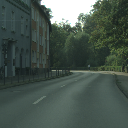

masked!


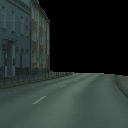

In [3]:
from mask import apply_mask


to_tensor = transforms.Compose([
    transforms.ToTensor(),
])

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

# 读取一张图片
# test_path = '/root/autodl-tmp/Cityscapes_C/test/'
# img_list = os.listdir(test_path)
# img_path = test_path + random.choice(img_list)
img_path =('/root/autodl-tmp/Cityscapes_C/test/munster_000161_000019_leftImg8bit_0.png')
print(img_path)

img = Image.open(img_path)
img.save(f"original_img.png")
img.show()

# 使用mask遮罩
mask_path = 'mask/mask_10.png'
img = apply_mask(img_path, mask_path, 'masked_img.png')
img.show()


### 3. 图像加噪

Input shape: torch.Size([1, 3, 128, 128])


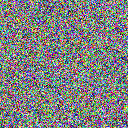

torch.Size([1, 3, 128, 128])


In [4]:
# 使用noise_scheduler加噪
sample_image = to_tensor(img).unsqueeze(0)
print('Input shape:', sample_image.shape)
noise = torch.randn(sample_image.shape)
# 设置加噪步长
timesteps = torch.LongTensor([800])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

# 将图片像素值[-1,1]映射到[0,255]
img = Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])
img.show()
print(noisy_image.shape)

### 4. 图像去噪

  0%|          | 0/1000 [00:00<?, ?it/s]

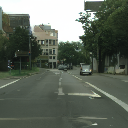

In [5]:
from DenoisePipeline import DenoisePipeline
# 加载模型和建立去噪pipeline
model_path = "/root/diffusers_main/output/unet/"
model = UNet2DModel.from_pretrained(model_path)
model = model.to('cuda')
pipeline = DenoisePipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

# 图像去噪
img = pipeline(noisy_image, batch_size = 1, num_inference_steps=2000).images
image_grid = make_grid(img, rows=1, cols=1)
image_grid.save(f"denoised_img.png")
image_grid.show()

### 5. 图像填补

filled!


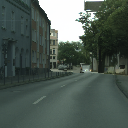

In [6]:
# 使用去噪的图像对原图进行填补
from mask import fill_masked
fill_img = fill_masked("original_img.png", 'denoised_img.png', mask_path, 'repaint_img.png')
fill_img.show()

填补对比:

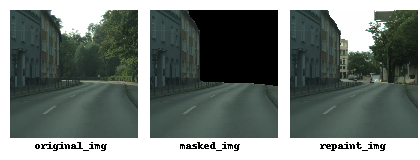

In [7]:
from frame import iamge_frame
iamge_frame('/root/diffusers_main/')